# 1 Introduction

This notebook contains the experimental procedure in order to compare and visualize various undersampling and oversampling methods on image data.

# 2 Imports

#### 2.1 General

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
from math import sqrt

#### 2.2 scikit-learn

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.datasets import make_classification, fetch_mldata
from sklearn.preprocessing import label_binarize

#### 2.3 imbalance-learn

In [3]:
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.datasets import make_imbalance

# 3 Functions

#### 3.1 Helper function

In [4]:
def measures(estimator, X, y):
    y_predicted = estimator.predict(X)
    true_positive = (y_predicted == 1)[y == 1].sum()
    false_positive = (y_predicted == 1)[y == 0].sum()
    true_negative = (y_predicted == 0)[y == 0].sum()
    false_negative = (y_predicted == 0)[y == 1].sum()
    return true_positive, false_positive, true_negative, false_negative

#### 3.2 F-measure

In [5]:
def F_measure(estimator, X, y):
    true_positive, false_positive, true_negative, false_negative = measures(estimator, X, y)
    return 2 * true_positive / (2 * true_positive + false_positive + false_negative)

#### 3.3 G-mean

In [6]:
def G_mean(estimator, X, y):
    true_positive, false_positive, true_negative, false_negative = measures(estimator, X, y)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    return sqrt(sensitivity * specificity)

# 4 Load image data

#### 4.1 Load and append datasets to container

In [7]:
datasets = []
datasets_names = ["MNIST original"]
for dataset_name in datasets_names:
    datasets.append(fetch_mldata(dataset_name, data_home="."))

#### 4.2. Binarize the target variable

In [8]:
imbalanced_datasets = []
classes = [(1, 7)]
for ind, dataset in enumerate(datasets):
    X, y = dataset.data, dataset.target.astype(np.int64)
    keep_indices = (y == classes[ind][0]) | (y == classes[ind][1])
    imbalanced_datasets.append(make_imbalance(X[keep_indices], y[keep_indices], ratio=0.01, random_state=0))

#### 4.2 Plot image data

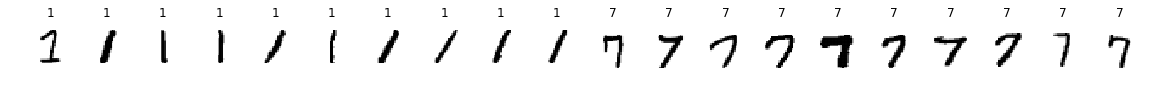

In [9]:
plt.rcParams['figure.figsize'] = (20, 20)
for dataset_ind, imbalanced_dataset in enumerate(imbalanced_datasets):
    fig, ax = plt.subplots(1, 20)
    X, y = imbalanced_dataset
    img_dim = int(sqrt(X.shape[1]))
    X = X.reshape(X.shape[0], img_dim, -1)
    maj_class_label, min_class_label = classes[dataset_ind]
    samples_indices = choices(np.where(y == maj_class_label)[0], k=10) + choices(np.where(y == min_class_label)[0], k=10)
    for ind, sample_index in enumerate(samples_indices):    
        ax[ind].imshow(X[sample_index], cmap='gray_r')
        ax[ind].axis('off')
        ax[ind].set_title(y[sample_index])
plt.show()

In [10]:
datasets_description = pd.DataFrame({}, columns=["# of features", "# of instances", "# of minority instances", "# of majority instances", "Imbalanced Ratio"])
for ind, (X, y) in enumerate(imbalanced_datasets):
    num_features = X.shape[1]
    num_instances = y.size
    maj_class_label, min_class_label = classes[ind]
    num_minority_instances = (y == min_class_label).sum()
    num_majority_instances = (y == maj_class_label).sum()
    IR = round(num_majority_instances / num_minority_instances, 2)
    datasets_description.loc[len(datasets_description)] = [num_features, num_instances, num_minority_instances, num_majority_instances, IR]
data_types = ["object", "object", "int64", "int64", "int64", "int64", "float64"]
for ind, feature in enumerate(datasets_description.columns):
    datasets_description[feature] = datasets_description[feature].astype(data_types[ind])
datasets_description

,# of features,# of instances,# of minority instances,# of majority instances,Imbalanced Ratio
0,784,7955,78,7877,100


# 5 Experiment

##### 5.1 Parameters

In [11]:
cv_scores = []
metrics = ['roc_auc', F_measure, G_mean]
random_states = [5 * i for i in range(3)]

#### 5.2 Run experiment

In [12]:
for random_state in random_states:
    cv = StratifiedKFold(n_splits=3, random_state=random_state)
    algorithms = [LogisticRegression(random_state=random_state)]
    methods = [None, RandomOverSampler(random_state=random_state), SMOTE(random_state=random_state, k_neighbors=3)]
    for algorithm in algorithms:
        for ind, (X, y) in enumerate(imbalanced_datasets):
            y = label_binarize(y, classes=classes[ind]).reshape(y.size)
            for method in methods:
                for metric in metrics:
                    if method is None:
                        clf = algorithm
                    else:
                        clf = make_pipeline(method, algorithm)
                    cv_scores.append(cross_val_score(clf, X, y, cv=cv, scoring=metric).mean())

#### 5.3 Results parameters

In [14]:
algorithms_names = ["LR"]
metrics_names = ["AUC", "F", "G"]
methods_names = ["None", "Random", "SMOTE"]

#### 5.4 Mean results

In [15]:
mean_cv_scores = np.array(cv_scores).reshape(len(random_states), -1).mean(axis=0).reshape(len(algorithms), len(imbalanced_datasets), len(methods), len(metrics))
mean_results = pd.DataFrame()
for ind1, alg_name in enumerate(algorithms_names):
    for ind2, ds_name in enumerate(datasets_names):
        partial_results = pd.DataFrame(mean_cv_scores[ind1, ind2, :, :].transpose(), columns=methods_names)
        partial_results.insert(0, "Metric", metrics_names)
        partial_results.insert(0, "Dataset", ds_name)
        partial_results.insert(0, "Algorithm", alg_name)
        mean_results = pd.concat([mean_results, partial_results])
mean_results = mean_results.reset_index(drop=True)

#### 5.5 Standard deviation results

In [16]:
std_cv_scores = np.array(cv_scores).reshape(len(random_states), -1).std(axis=0).reshape(len(algorithms), len(imbalanced_datasets), len(methods), len(metrics))
std_results = pd.DataFrame()
for ind1, alg_name in enumerate(algorithms_names):
    for ind2, ds_name in enumerate(datasets_names):
        partial_results = pd.DataFrame(std_cv_scores[ind1, ind2, :, :].transpose(), columns=methods_names)
        partial_results.insert(0, "Metric", metrics_names)
        partial_results.insert(0, "Dataset", ds_name)
        partial_results.insert(0, "Algorithm", alg_name)
        std_results = pd.concat([std_results, partial_results])
std_results = std_results.reset_index(drop=True)

#### 5.6 Oversampling methods ranking

In [17]:
ranking = mean_results.apply(lambda row: len(row[3:]) - row[3:].argsort().argsort(), axis=1)
aggregated_ranking = round(pd.concat([mean_results[["Algorithm", "Metric"]], ranking], axis=1).groupby(["Algorithm", "Metric"]).mean(), 2)
aggregated_ranking

None  Random  SMOTE
Algorithm Metric                     
LR        AUC        1       2      3
          F          3       2      1
          G          3       2      1

#### 5.7 Friedman test

In [18]:
friedman_results = pd.DataFrame({}, columns=["Algorithm", "Metric", "p-value"])
for alg_name in algorithms_names:
    for metric_name in metrics_names:
        partial_ranking = pd.concat([mean_results[["Algorithm", "Metric"]], ranking], axis=1)[(mean_results["Algorithm"] == alg_name) & (mean_results["Metric"] == metric_name)]
        friedman_inputs = []
        for method_name in methods_names:
            friedman_inputs.append(partial_ranking[method_name])
        pvalue = round(scipy.stats.friedmanchisquare(*friedman_inputs).pvalue, 2)
        friedman_results.loc[len(friedman_results)] = [alg_name, metric_name, pvalue]
friedman_results

,Algorithm,Metric,p-value
0,LR,AUC,0.37
1,LR,F,0.37
2,LR,G,0.37
